In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

# Transformações para treino (com rotação)
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),  # Rotaciona entre -15° e +15°
    transforms.RandomHorizontalFlip(),  # Flip horizontal aleatório
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translação aleatória
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Transformações para teste (sem rotação)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets originais
train_dataset = datasets.MNIST(root='data', train=True, transform=test_transform, download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=test_transform, download=True)

# Datasets com imagens rotacionadas
train_dataset_rot = datasets.MNIST(root='data', train=True, transform=train_transform, download=True)

# Junta os dois conjuntos (originais + rotacionados)
train_dataset_total = ConcatDataset([train_dataset, train_dataset_rot])

# Loaders
train_loader = DataLoader(train_dataset_total, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [3]:
# from torchvision import datasets
# from torch.utils.data import DataLoader

# # Download training data from open datasets.
# train_dataset = datasets.FashionMNIST(
#     root="data",
#     train=True,
#     download=True,
#     transform=ToTensor(),
# )

# # Download test data from open datasets.
# test_dataset = datasets.FashionMNIST(
#     root="data",
#     train=False,
#     download=True,
#     transform=ToTensor(),
# )

# batch_size = 64

# # Create data loaders.
# train_loader = DataLoader(train_dataset, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [4]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(

            nn.Linear(28*28, 128), 
            nn.BatchNorm1d(128), #Normalização em batch
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

Usando cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [6]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train_and_validate(model, train_loader, test_loader, loss_fn, optimizer, epochs):
    device = next(model.parameters()).device

    for epoch in range(epochs):
        # ------------------ TREINAMENTO ------------------
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Acurácia de treino
            _, predicted = torch.max(outputs.data, 1)
            total_train += y.size(0)
            correct_train += (predicted == y).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # ------------------ VALIDAÇÃO ------------------
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for X, y in test_loader:
                X = X.to(device)
                y = y.to(device)

                outputs = model(X)
                loss_val = loss_fn(outputs, y)
                val_running_loss += loss_val.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += y.size(0)
                correct_val += (predicted == y).sum().item()

        avg_val_loss = val_running_loss / len(test_loader)
        val_acc = 100 * correct_val / total_val
        test_losses.append(avg_val_loss)
        test_accuracies.append(val_acc)

        # ------------------ EXIBIÇÃO ------------------
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Acc: {val_acc:.2f}%")


Epoch [1/20] | Train Loss: 0.6393 | Val Loss: 0.1656 | Train Acc: 79.94% | Val Acc: 95.10%
Epoch [2/20] | Train Loss: 0.3788 | Val Loss: 0.1200 | Train Acc: 87.77% | Val Acc: 96.28%
Epoch [3/20] | Train Loss: 0.3289 | Val Loss: 0.0966 | Train Acc: 89.46% | Val Acc: 96.78%
Epoch [4/20] | Train Loss: 0.3002 | Val Loss: 0.0853 | Train Acc: 90.33% | Val Acc: 97.09%
Epoch [5/20] | Train Loss: 0.2812 | Val Loss: 0.0785 | Train Acc: 90.91% | Val Acc: 97.39%
Epoch [6/20] | Train Loss: 0.2693 | Val Loss: 0.0730 | Train Acc: 91.27% | Val Acc: 97.64%
Epoch [7/20] | Train Loss: 0.2580 | Val Loss: 0.0717 | Train Acc: 91.69% | Val Acc: 97.54%
Epoch [8/20] | Train Loss: 0.2505 | Val Loss: 0.0718 | Train Acc: 91.85% | Val Acc: 97.61%
Epoch [9/20] | Train Loss: 0.2391 | Val Loss: 0.0740 | Train Acc: 92.38% | Val Acc: 97.45%
Epoch [10/20] | Train Loss: 0.2342 | Val Loss: 0.0659 | Train Acc: 92.41% | Val Acc: 97.82%
Epoch [11/20] | Train Loss: 0.2345 | Val Loss: 0.0643 | Train Acc: 92.42% | Val Acc: 97.8

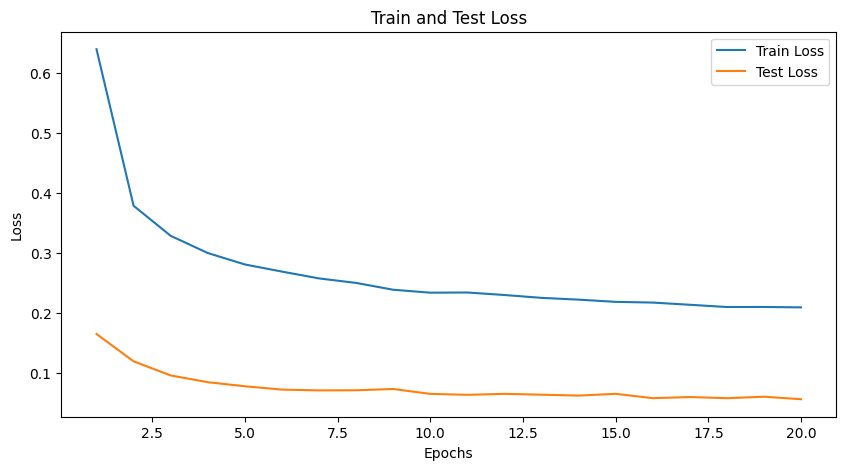

In [7]:
num_epochs = 20
train_and_validate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()